In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS exclusion curve

In [2]:
cms = pd.read_pickle('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/DMsimp_spin-0_Monojet_DF.pcl')
cmsCurve = np.genfromtxt('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/Signalstrengthlimits,pseudoscalarmediator.csv',
                        skip_header=14,names=True,delimiter=',',skip_footer=60)

### Load Recast Data

In [3]:
match_nobias = pd.read_pickle('../CMS-EXO-20-004/pseudoscalar_0j1j.pcl')

match_bias = pd.read_pickle('../pseudoscalar_match_bias.pcl')

single_bias = pd.read_pickle('../CMS-EXO-20-004/pseudoscalar_single_bias.pcl')

single_nobias = pd.read_pickle('../CMS-EXO-20-004/pseudoscalar_single_nobias.pcl')


# recastData = pd.concat([recastData1, recastData2, recastData3, recastData4], ignore_index=True)

In [4]:
cms['$\\mu^{UL}_{exp}$'].max()

135.59329846504284

### Get all model points

In [5]:
models = []
mCols = ['Coupling','Mode','$m_{med}$','$m_{DM}$','$g_{DM}$', '$g_{q}$']
for row in match_nobias[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
        
for row in match_bias[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
        
for row in single_nobias[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
        
for row in single_bias[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
        
print('%i models loaded' %len(models))

9 models loaded


### Get model parameters

In [6]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': 'Pseudoscalar', 'Mode': 'DM+QCDjets', '$m_{med}$': [800.0, 450.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 350.0], '$m_{DM}$': 1.0, '$g_{DM}$': 1.0, '$g_{q}$': 1.0}
Coupling = Pseudoscalar
Mode = DM+QCDjets
$g_{DM}$ = 1.0
$g_{q}$ = 1.0


In [7]:
# Remove duplicated data from other datasets
match_bias = match_bias[match_bias['Data-takingperiod'] == 2017]
match_nobias = match_nobias[match_nobias['Data-takingperiod'] == 2017]
single_bias = single_bias[single_bias['Data-takingperiod'] == 2017]
single_nobias = single_nobias[single_nobias['Data-takingperiod'] == 2017]
cms = cms[cms['Data-takingperiod'] == 2017]

### Get all model points with common models to CMS data

In [8]:
keys = list(cms[mCols].columns.values)
i1 = match_bias.set_index(keys).index
i2 = cms.set_index(keys).index
match_bias = match_bias[i1.isin(i2)]
cmsData = cms[i2.isin(i1)]
print(len(match_bias),len(cmsData))

9 9


In [9]:
match_bias.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                       ascending=[False,False,True,True,False],ignore_index=True)
    
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                    ascending=[False,False,True,True,False],ignore_index=True)  

/tmp/ipykernel_21729/812465587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,


In [10]:
match_bias = match_bias[(match_bias['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

In [11]:
kfactor = 1.
match_bias['UL ratio'] = (match_bias['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

In [12]:
keys = list(cms[mCols].columns.values)
i1 = match_nobias.set_index(keys).index
i2 = cms.set_index(keys).index
match_nobias = match_nobias[i1.isin(i2)]
cmsData = cms[i2.isin(i1)]
print(len(match_nobias),len(cmsData))

8 8


In [13]:
match_nobias.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)
    
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)  

/tmp/ipykernel_21729/3362546509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,


In [14]:
match_nobias = match_nobias[(match_nobias['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

In [15]:
kfactor = 1.
match_nobias['UL ratio'] = (match_nobias['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

In [16]:
keys = list(cms[mCols].columns.values)
i1 = single_bias.set_index(keys).index
i2 = cms.set_index(keys).index
single_bias = single_bias[i1.isin(i2)]
cmsData = cms[i2.isin(i1)]
print(len(single_bias),len(cmsData))

9 9


In [17]:
single_bias.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)
    
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)  

/tmp/ipykernel_21729/1649593143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,


In [18]:
single_bias = single_bias[(single_bias['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

In [19]:
kfactor = 1.
single_bias['UL ratio'] = (single_bias['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

In [20]:
keys = list(cms[mCols].columns.values)
i1 = single_nobias.set_index(keys).index
i2 = cms.set_index(keys).index
single_nobias = single_nobias[i1.isin(i2)]
cmsData = cms[i2.isin(i1)]
print(len(single_nobias),len(cmsData))

9 9


In [21]:
single_nobias.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)
    
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)  

/tmp/ipykernel_21729/4159656085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,


In [22]:
single_nobias = single_nobias[(single_nobias['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

In [23]:
kfactor = 1.
single_nobias['UL ratio'] = (single_nobias['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

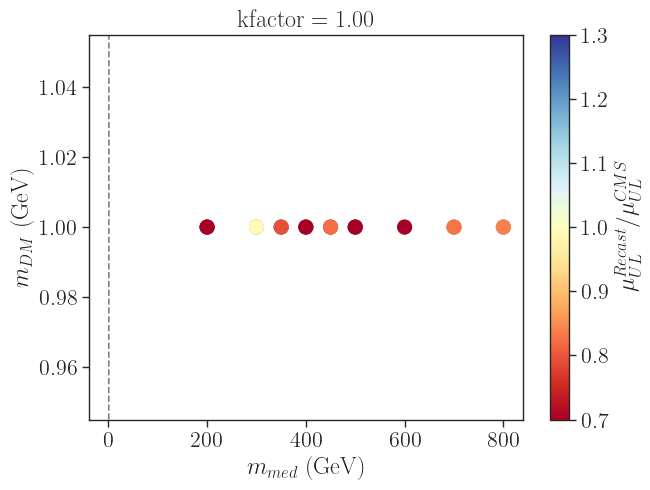

In [24]:
fig = plt.figure(figsize=(7,5))

plt.scatter(x=match_bias['$m_{med}$'],y=match_bias['$m_{DM}$'],vmin=0.7,vmax=1.3,
            c=match_bias['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100,label=r'$0j + 1j$ + bias')

plt.scatter(x=match_nobias['$m_{med}$'],y=match_nobias['$m_{DM}$'],vmin=0.7,vmax=1.3,
            c=match_nobias['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100,label=r'$0j + 1j$')

plt.scatter(x=single_bias['$m_{med}$'],y=single_bias['$m_{DM}$'],vmin=0.7,vmax=1.3,
            c=single_bias['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100,label=r'$1j$ + bias')

plt.scatter(x=single_nobias['$m_{med}$'],y=single_nobias['$m_{DM}$'],vmin=0.7,vmax=1.3,
            c=single_nobias['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100,label=r'$1j$')

cbar = plt.colorbar(label=r'$\mu^{Recast}_{UL}/\mu^{CMS}_{UL}$')
plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

# cbar.set_ticks([0.5,0.75,0.9,1.0,1.1,1.25,1.5])

plt.xlabel(r'$m_{med}$ (GeV)')
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
# plt.yscale('log')
plt.title('kfactor = %1.2f' %kfactor)
plt.show()

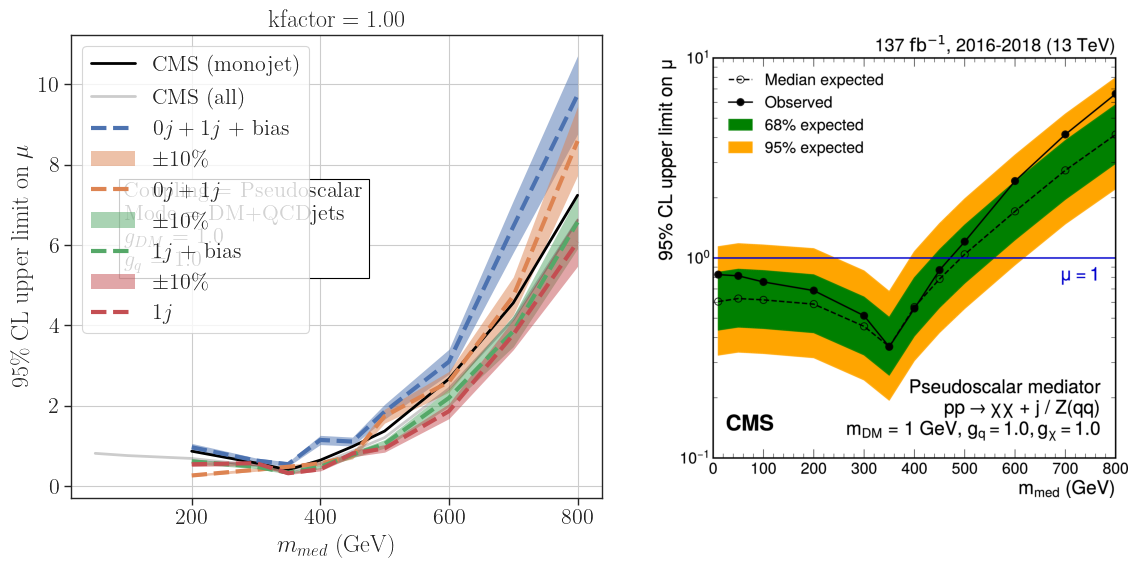

In [25]:
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
ax[0].plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax[0].plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
           linewidth=2,color='black',alpha=0.2)

ax[0].fill_between(match_bias['$m_{med}$'],1.1*match_bias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*match_bias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0)
    
ax[0].plot(match_bias['$m_{med}$'],match_bias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$0j + 1j$ + bias',linewidth=3,markersize=7)

ax[0].fill_between(match_nobias['$m_{med}$'],1.1*match_nobias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*match_nobias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax[0].plot(match_nobias['$m_{med}$'],match_nobias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$0j + 1j$',linewidth=3,markersize=7)

ax[0].fill_between(single_bias['$m_{med}$'],1.1*single_bias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*single_bias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax[0].plot(single_bias['$m_{med}$'],single_bias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$1j$ + bias',linewidth=3,markersize=7)

ax[0].fill_between(single_nobias['$m_{med}$'],1.1*single_nobias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*single_nobias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax[0].plot(single_nobias['$m_{med}$'],single_nobias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$1j$',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax[0].set_xlabel(r'$m_{med}$ (GeV)')
ax[0].set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
ax[0].set_title('kfactor = %1.2f' %kfactor)
ax[0].text(0.1,0.5,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax[0].transAxes)
ax[0].legend()
ax[0].grid()

cmsPlot = plt.imread('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/CMS-EXO-20-004_Figure_009-b.png')
ax[1].imshow(cmsPlot)
ax[1].axis('off')
# plt.savefig('cms-exo-20-004-pseudoscalar-comp.png')

plt.tight_layout()
plt.show()

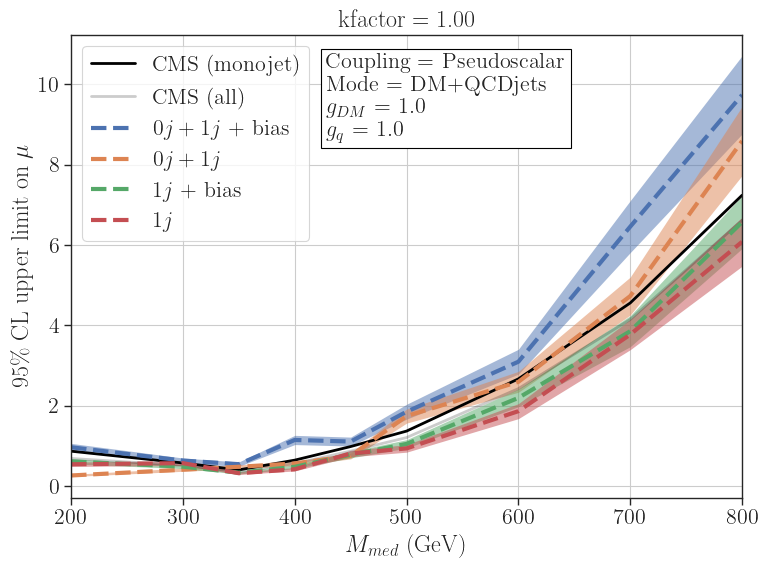

In [26]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax.plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
         linewidth=2,color='black',alpha=0.2)

ax.fill_between(match_bias['$m_{med}$'],1.1*match_bias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*match_bias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0)
    
ax.plot(match_bias['$m_{med}$'],match_bias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$0j + 1j$ + bias',linewidth=3,markersize=7)

ax.fill_between(match_nobias['$m_{med}$'],1.1*match_nobias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*match_nobias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0)
    
ax.plot(match_nobias['$m_{med}$'],match_nobias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$0j + 1j$',linewidth=3,markersize=7)

ax.fill_between(single_bias['$m_{med}$'],1.1*single_bias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*single_bias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0)
    
ax.plot(single_bias['$m_{med}$'],single_bias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$1j$ + bias',linewidth=3,markersize=7)

ax.fill_between(single_nobias['$m_{med}$'],1.1*single_nobias['$\mu^{UL}_{obs}$']/kfactor,
                   0.9*single_nobias['$\mu^{UL}_{obs}$']/kfactor,alpha=0.5,linewidth=0)
    
ax.plot(single_nobias['$m_{med}$'],single_nobias['$\mu^{UL}_{obs}$']/kfactor,
           linestyle='--',label=r'$1j$',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax.set_xlabel(r'$M_{med}$ (GeV)')
ax.set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
plt.xlim(200,800)
ax.set_title('kfactor = %1.2f' %kfactor)
ax.text(.38,0.78,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax.transAxes)
ax.legend()
ax.grid()

plt.savefig('cms-exo-20-004-pseudoscalar-comparison-versions.png')
plt.tight_layout()
plt.show()

In [27]:
match_bias.T

,0,1,2,3,4,5,6,7,8
Coupling,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,200.0,300.0,350.0,400.0,450.0,500.0,600.0,700.0,800.0
$m_{DM}$,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Data-takingperiod,2017,2017,2017,2017,2017,2017,2017,2017,2017
Luminosity (1/fb),41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5
bin_250.0_280.0,2795.236059,2414.003616,3063.319921,1527.69005,948.588853,605.224022,311.864227,156.171539,56.517053
bin_250.0_280.0_ErrorPlus,169.426761,111.097235,158.594467,88.472689,56.047077,44.826276,38.551197,20.53335,3.38486
bin_250.0_280.0_ErrorMinus,169.426761,111.097235,158.594467,88.472689,56.047077,44.826276,38.551197,20.53335,3.38486
bin_280.0_310.0,1597.851434,1625.589951,1902.585476,1434.188188,705.256315,411.698552,191.593038,98.888826,47.547871


In [28]:
match_nobias.T

,0,1,2,3,4,5,6,7
Coupling,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,200.0,350.0,400.0,450.0,500.0,600.0,700.0,800.0
$m_{DM}$,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Data-takingperiod,2017,2017,2017,2017,2017,2017,2017,2017
Luminosity (1/fb),41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5
bin_250.0_280.0,3026.646621,3210.317991,1373.560972,996.743787,631.611622,259.29101,146.992097,64.437875
bin_250.0_280.0_ErrorPlus,315.549723,301.955638,130.372638,80.581959,48.585509,19.272949,9.259632,4.150808
bin_250.0_280.0_ErrorMinus,315.549723,301.955638,130.372638,80.581959,48.585509,19.272949,9.259632,4.150808
bin_280.0_310.0,1644.916642,1814.52756,1138.446931,671.010523,426.057544,200.556582,94.494919,49.464759


In [29]:
single_bias.T

,0,1,2,3,4,5,6,7,8
Coupling,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar,Pseudoscalar
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,200.0,300.0,350.0,400.0,450.0,500.0,600.0,700.0,800.0
$m_{DM}$,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Data-takingperiod,2017,2017,2017,2017,2017,2017,2017,2017,2017
Luminosity (1/fb),41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5
bin_250.0_280.0,2759.647258,3003.747048,3485.016568,1877.983115,1056.626279,666.387532,271.696805,140.230764,66.712269
bin_250.0_280.0_ErrorPlus,108.63972,113.492145,135.986283,74.802353,41.741702,27.238533,11.553689,6.099958,2.95983
bin_250.0_280.0_ErrorMinus,108.63972,113.492145,135.986283,74.802353,41.741702,27.238533,11.553689,6.099958,2.95983
bin_280.0_310.0,1919.597141,2192.001211,2502.037466,1327.757659,738.677075,513.210312,221.422989,110.952132,56.134345


In [30]:
print(match_bias[['Total xsec (pb)', '$m_{med}$']],'\n', match_nobias[['Total xsec (pb)', '$m_{med}$']], '\n',
      single_bias[['Total xsec (pb)', '$m_{med}$']], '\n', single_nobias[['Total xsec (pb)', '$m_{med}$']])

   Total xsec (pb)  $m_{med}$
0        13.847163      200.0
1         9.182676      300.0
2        10.029491      350.0
3         4.318029      400.0
4         2.199772      450.0
5         1.234896      500.0
6         0.451519      600.0
7         0.196879      700.0
8         0.093486      800.0 
    Total xsec (pb)  $m_{med}$
0        13.861900      200.0
1        10.117039      350.0
2         4.298669      400.0
3         2.215509      450.0
4         1.241360      500.0
5         0.460315      600.0
6         0.198199      700.0
7         0.093586      800.0 
    Total xsec (pb)  $m_{med}$
0         2.053501      200.0
1         1.711336      300.0
2         1.919079      350.0
3         0.928323      400.0
4         0.519253      450.0
5         0.320781      500.0
6         0.132890      600.0
7         0.062470      700.0
8         0.031739      800.0 
    Total xsec (pb)  $m_{med}$
0         2.045991      200.0
1         1.711952      300.0
2         1.928582      350.0
3   

In [31]:
binCols = [c for c in single_bias.columns if ('bin_' in c and not 'Error' in c)]
 
single_bias['TotalYield'] = single_bias[binCols].sum(axis=1)/single_bias['HCALmitigation($\\phi^{miss}$)']
match_bias['TotalYield'] = match_bias[binCols].sum(axis=1)/match_bias['HCALmitigation($\\phi^{miss}$)']
single_nobias['TotalYield'] = single_nobias[binCols].sum(axis=1)/single_nobias['HCALmitigation($\\phi^{miss}$)']
match_nobias['TotalYield'] = match_nobias[binCols].sum(axis=1)/match_nobias['HCALmitigation($\\phi^{miss}$)']

# Add luminosity
# Compute total cross-section (total yield/eff)
# for the corresponding luminosities
single_bias['xsec'] = single_bias['TotalYield']/(1e3*single_bias['Luminosity (1/fb)'])
match_bias['xsec'] = match_bias['TotalYield']/(1e3*single_bias['Luminosity (1/fb)'])
match_nobias['xsec'] = match_nobias['TotalYield']/(1e3*single_bias['Luminosity (1/fb)'])
single_nobias['xsec'] = single_nobias['TotalYield']/(1e3*single_bias['Luminosity (1/fb)'])

# Remove auxiliary columns:
single_bias.drop('TotalYield',axis='columns',inplace=True)
single_nobias.drop('TotalYield',axis='columns',inplace=True)
match_bias.drop('TotalYield',axis='columns',inplace=True)
match_nobias.drop('TotalYield',axis='columns',inplace=True)

In [32]:
print(match_bias[['xsec', '$m_{med}$']],'\n', match_nobias[['xsec', '$m_{med}$']], '\n',
      single_bias[['xsec', '$m_{med}$']], '\n', single_nobias[['xsec', '$m_{med}$']])

        xsec  $m_{med}$
0  13.691257      200.0
1   9.193382      300.0
2   9.860551      350.0
3   4.343769      400.0
4   2.185946      450.0
5   1.265580      500.0
6   0.459962      600.0
7   0.198360      700.0
8   0.090982      800.0 
         xsec  $m_{med}$
0  14.060668      200.0
1  10.102159      350.0
2   4.301827      400.0
3   2.216085      450.0
4   1.217475      500.0
5   0.464283      600.0
6   0.197929      700.0
7   0.092828      800.0 
        xsec  $m_{med}$
0  2.047225      200.0
1  1.703359      300.0
2  1.942869      350.0
3  0.922472      400.0
4  0.514764      450.0
5  0.325243      500.0
6  0.132378      600.0
7  0.061831      700.0
8  0.031660      800.0 
        xsec  $m_{med}$
0  2.026249      200.0
1  1.719306      300.0
2  1.903668      350.0
3  0.933021      400.0
4  0.527359      450.0
5  0.320536      500.0
6  0.134142      600.0
7  0.062930      700.0
8  0.031831      800.0


In [37]:
print(cmsData['Total xsec-pT150 (pb)'],'\n', cmsData['$m_{med}$'])

0    1.812468
1    1.505122
2    1.682038
3    0.812798
4    0.460352
5    0.278620
6    0.116280
7    0.054702
8    0.027736
Name: Total xsec-pT150 (pb), dtype: float64 
 0    200.0
1    300.0
2    350.0
3    400.0
4    450.0
5    500.0
6    600.0
7    700.0
8    800.0
Name: $m_{med}$, dtype: float64
